## Search for dividend growth companies

### Update Oct 2023

We will begin our search with in Netherlands, which currently seems to be a booming economy and has relatively low dividend tax 15% (https://taxsummaries.pwc.com/netherlands/corporate/withholding-taxes).

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
import datetime
import pytz


In [2]:
# dfs = pd.read_html("https://www.dividendmax.com/stock-exchange-listings/netherlands/euronext-amsterdam")
df = pd.read_csv("amsterdam_exch_2023-10-14.csv", sep=";")
def flatten(l):
    return [item for sublist in l for item in sublist]
pd.DataFrame(flatten(df["Market"].str.split(",").to_list()))[0].unique()

FileNotFoundError: [Errno 2] No such file or directory: 'amsterdam_exch_2023-10-14.csv'

In [ ]:
df.iloc[0]["Symbol"]

'AALB'

In [ ]:
symbol = "QWABS"
company = yf.Ticker(symbol + ".PA")
if len(company.dividends):
    div_df = pd.DataFrame(company.dividends).reset_index()
    tz = pytz.timezone(str(div_df["Date"].iloc[0].tz))
    div_df_10yrs = div_df[div_df["Date"] >= datetime.datetime(2013, 1, 1, tzinfo=tz)]
    div_df_10yrs_grouped = div_df_10yrs.groupby(div_df_10yrs["Date"].dt.year).sum(numeric_only=True).reset_index()
    div_df_10yrs_grouped["pct_change"] = div_df_10yrs_grouped["Dividends"].pct_change(periods=1)
    div_df_10yrs_grouped["pct_change_10"] = div_df_10yrs_grouped["Dividends"].pct_change(periods=10)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
pd.DataFrame(company.dividends).reset_index()
if len(company.dividends):
    print("hello")

In [ ]:
year_10 = 10 if len(div_df_10yrs_grouped) > 10 else len(div_df_10yrs_grouped) - 1
year_5 = 5 if len(div_df_10yrs_grouped) > 5 else len(div_df_10yrs_grouped) - 1
res = {
    "growth_10": div_df_10yrs_grouped["Dividends"].pct_change(periods=year_10).iloc[-1],
    "growth_yy_10": ((div_df_10yrs_grouped["Dividends"].shift(-year_10) / div_df_10yrs_grouped["Dividends"]) ** (1 / year_10) - 1).dropna().iloc[-1],
    "growth_yy_5": ((div_df_10yrs_grouped["Dividends"].shift(-year_5) / div_df_10yrs_grouped["Dividends"]) ** (1 / year_5) - 1).dropna().iloc[-1],
    "growth_yy_3": ((div_df_10yrs_grouped["Dividends"].shift(-3) / div_df_10yrs_grouped["Dividends"]) ** (1 / 3) - 1).dropna().iloc[-1],
    "growth_yy_1": ((div_df_10yrs_grouped["Dividends"].shift(-1) / div_df_10yrs_grouped["Dividends"]) ** (1 / 1) - 1).dropna().iloc[-1],
}
res

{'growth_10': 0.6666666666666667,
 'growth_yy_10': 0.05840007284126747,
 'growth_yy_5': 0.008548252303932413,
 'growth_yy_3': 0.06265856918261115,
 'growth_yy_1': 0.14285714285714302}

In [ ]:
# pd.Series([div_df_10yrs_grouped["Date"].min() + i for i in range(len(div_dfo_10yrs_grouped))]).diff(div_df_10yrs_grouped["Date"])
# div_df_10yrs_grouped["Date"].min(), div_df_10yrs_grouped["Date"].max()

,Date,Dividends,pct_change,pct_change_10
9,2023,1.20,0.142857,NaN
8,2022,1.05,-0.045455,NaN
7,2020,1.10,0.100000,NaN
6,2019,1.00,0.428571,NaN
5,2018,0.70,-0.391304,NaN
4,2017,1.15,0.150000,NaN
3,2016,1.00,-0.090909,NaN
2,2015,1.10,0.100000,NaN
1,2014,1.00,0.388889,NaN
0,2013,0.72,NaN,NaN


In [ ]:
q_low = div_df_10yrs_grouped["pct_change"].abs().quantile(0.1)
q_high = div_df_10yrs_grouped["pct_change"].quantile(0.9)
div_df_10yrs_grouped[(div_df_10yrs_grouped["pct_change"].abs() > q_low) & (div_df_10yrs_grouped["pct_change"].abs() < q_high)]["pct_change"].mean()

0.36161003606346187

<Axes: xlabel='Date'>

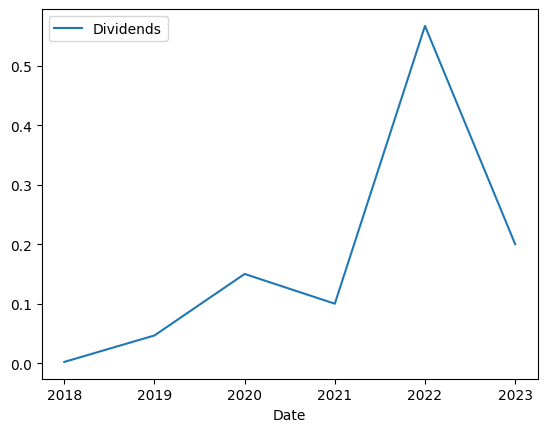

In [ ]:
div_df_10yrs_grouped.plot(x="Date", y="Dividends")

In [ ]:
div_df_10yrs_grouped["Dividends"].pct_change(periods=10)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10    2.171429
Name: Dividends, dtype: float64

In [ ]:
((div_df_10yrs_grouped["Dividends"].shift(-5) / div_df_10yrs_grouped["Dividends"]) ** (1 / 5) - 1)
pd.concat([div_df_10yrs_grouped["Dividends"].shift(-5), div_df_10yrs_grouped["Dividends"]], axis=1)

,Dividends,Dividends
0,0.2,0.002222
1,NaN,0.046667
2,NaN,0.150000
3,NaN,0.100000
4,NaN,0.566667
5,NaN,0.200000


In [ ]:
div_df_10yrs_grouped[(np.abs(stats.zscore(div_df_10yrs_grouped["Dividends"])) > 2)].to_dict(orient="records")


[{'Date': 2020,
  'Dividends': 1.6,
  'pct_change': 1.1333333333333333,
  'pct_change_10': nan}]

### Search for low debt companies

In [ ]:
balance = company.balance_sheet
income = company.income_stmt
cash = company.cash_flow
latest = balance.columns.sort_values()[-1]

In [ ]:
x.loc["Diluted Average Shares"]

2019-12-31    24657249.0
2020-12-31    29585516.0
2021-12-31    29653872.0
2022-12-31    29617746.0
Name: Diluted Average Shares, dtype: object

In [ ]:
qlow = income.loc["Net Income"].quantile(0.02)
qhigh = income.loc["Net Income"].quantile(0.98)

income.loc["Net Income"][(income.loc["Net Income"] > qlow) & (income.loc["Net Income"] < qhigh)].mean()

359063000.0

In [ ]:
x = income.loc["Net Income"] / income.loc["Total Revenue"]

qlow = x.quantile(0.01)
qhigh = x.quantile(0.99)
x[(x > qlow) & (x < qhigh)].mean()

0.04322007980010193

In [ ]:
x[(x > qlow) & (x < qhigh)]

2022-12-31    0.056227
2019-12-31    0.030213
dtype: object

In [ ]:
x.sort_values()

2020-12-31     0.00598
2019-12-31    0.030213
2022-12-31    0.056227
2021-12-31    0.058757
dtype: object

In [ ]:
any(income.loc["Total Revenue"] == 0)

False

In [ ]:
div_df_10yrs_grouped["Dividends"].pct_change(periods=10)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Dividends, dtype: float64

In [ ]:
((income.sort_index(axis=1).loc["Diluted Average Shares"].shift(-2) / income.sort_index(axis=1).loc["Diluted Average Shares"]) ** (1 / 3) - 1).dropna().iloc[-1]

0.00036299635558334487

In [ ]:
pd.concat([income.sort_index(axis=1).loc["Diluted Average Shares"].shift(-2), income.sort_index(axis=1).loc["Diluted Average Shares"] ], axis=1)

,Diluted Average Shares,Diluted Average Shares
2019-12-31,29653872.0,24657249.0
2020-12-31,29617746.0,29585516.0
2021-12-31,None,29653872.0
2022-12-31,None,29617746.0


In [ ]:

all_years = pd.Series(range(div_df_10yrs_grouped["Date"].min(), div_df_10yrs_grouped["Date"].max() + 1))
missing_dividend_years = all_years[all_years.isin(div_df_10yrs_grouped["Date"]) == False]

missing_dividend_years.count()

1

In [ ]:
xx = income.sort_index(axis=1)
def get_growth_per_year(series, year):
    x = ((series.shift(-year) / series) ** (1 / year)) - 1
    return x.dropna().iloc[-1]

get_growth_per_year(xx.loc["Diluted Average Shares"], -3) if "Diluted Average Shares" in income.index and len(income.loc["Diluted Average Shares"].dropna()) == 4 else np.NaN

0.0630061924527705

In [ ]:
income.loc["Diluted Average Shares"]

2022-12-31    29617746.0
2021-12-31    29653872.0
2020-12-31    29585516.0
2019-12-31    24657249.0
Name: Diluted Average Shares, dtype: object

In [ ]:
res

{'growth_10': 0.6666666666666667,
 'growth_yy_10': 0.05840007284126747,
 'growth_yy_5': 0.008548252303932413,
 'growth_yy_3': 0.06265856918261115,
 'growth_yy_1': 0.14285714285714302}

In [ ]:
div_df

,Date,Dividends
0,2004-09-27 00:00:00-04:00,0.075
1,2005-07-19 00:00:00-04:00,0.150
2,2006-07-18 00:00:00-04:00,0.300
3,2007-07-18 00:00:00-04:00,0.480
4,2008-07-14 00:00:00-04:00,0.580


In [ ]:
div_df.style.applymap(lambda x: 'color: red' if x is int and x < 1 else 'color: white')

,Date,Dividends
0,2004-09-27 00:00:00-04:00,0.075000
1,2005-07-19 00:00:00-04:00,0.150000
2,2006-07-18 00:00:00-04:00,0.300000
3,2007-07-18 00:00:00-04:00,0.480000
4,2008-07-14 00:00:00-04:00,0.580000


In [ ]:
div_df["Dividends"].mean() / income.loc["Net Income"].mean()

1.6598882791062331e-09

In [ ]:
div_df_10yrs_grouped["Dividends"]

,Date,Dividends,pct_change,pct_change_10
0,2013,0.35,NaN,NaN
1,2014,0.41,0.171429,NaN
2,2015,0.46,0.121951,NaN
3,2016,0.52,0.130435,NaN
4,2017,0.58,0.115385,NaN
5,2018,0.65,0.120690,NaN
6,2019,0.75,0.153846,NaN
7,2020,1.60,1.133333,NaN
8,2021,0.60,-0.625000,NaN
9,2022,0.64,0.066667,NaN


In [ ]:
div_df_10yrs_grouped["Dividends"].mean() / income.loc["Diluted EPS"].mean()

0.3031620553359684

## Parse TIKR tables

In [2]:
dfs = pd.read_html("data/tikr/Texas Roadhouse, Inc. (TXRH).html")
len(dfs)

4

In [3]:
def parse_date(x):
    if x != "LTM":
        date = datetime.datetime.strptime(x, "%m/%d/%y")
        return str(date.year) + "-" + str(date.month)
    return x

def replacetonumbeR(s):
    if type(s).__name__ == "str":
        s = s.strip()
        if s == "-":
            s = 0
        else:
            s = s.replace(",","")
            if s.find("(") >= 0 and s.find(")") >= 0:
                s = s.replace("(","-").replace(")","")
            if s.find("%") >= 0:
                s = s.replace("%", "")
                s = float(s) / 100
    return s

def parse_table(t):
    t = t.set_index(t.columns[0])
    t = t.dropna(how='all').dropna(how='all', axis=1)
    t = t.drop([c for c in t.index if "YoY" in c])
    t = t.rename(columns=parse_date)
    t = t.applymap(lambda x:replacetonumbeR(x))
    t = t.astype(float)
    return t

income = parse_table(dfs[0])
income.head()

,2018-12,2019-12,2020-12,2021-12,2022-12,LTM
Income Statement | TIKR.com,,,,,,
Revenues,2457.450,2756.160,2398.120,3463.950,4014.920,4348.390
Total Revenues,2457.450,2756.160,2398.120,3463.950,4014.920,4348.390
Cost of Goods Sold,-1995.850,-2241.650,-2100.740,-2836.340,-3336.290,-3630.700
Gross Profit,461.600,514.510,297.390,627.600,678.630,717.690
% Gross Margins,0.188,0.187,0.124,0.181,0.169,0.165


In [4]:
income.loc["Revenues"].mean()

3239.831666666667

In [5]:
balance = parse_table(dfs[1])
balance.head()

,2018-12,2019-12,2020-12,2021-12,2022-12,LTM
Balance Sheet | TIKR.com,,,,,,
Cash And Equivalents,210.13,107.88,363.16,335.65,173.86,107.32
Total Cash And Short Term Investments,210.13,107.88,363.16,335.65,173.86,107.32
Accounts Receivable,92.11,99.31,98.42,161.36,150.26,60.54
Total Receivables,92.11,99.31,98.42,161.36,150.26,60.54
Inventory,18.83,20.27,22.36,31.60,38.02,38.12


In [6]:
pd.concat([balance.loc["Net Debt"], income.loc["Operating Income"], income.loc["Depreciation & Amortization"]], axis=1)

,Net Debt,Operating Income,Depreciation & Amortization
2018-12,-210.13,188.07,-101.22
2019-12,448.09,211.12,-115.54
2020-12,468.29,26.11,-117.88
2021-12,411.90,297.93,-126.76
2022-12,582.25,321.80,-137.24
LTM,632.49,342.47,-142.84


In [7]:
balance.loc["Total Debt"] / (income.loc["Operating Income"] - income.loc["Depreciation & Amortization"])

2018-12         NaN
2019-12    1.701984
2020-12    5.774290
2021-12    1.760202
2022-12    1.647155
LTM        1.524428
dtype: float64

In [8]:
cash = parse_table(dfs[2])
cash.head()

,2018-12,2019-12,2020-12,2021-12,2022-12,LTM
Cash Flow Statement | TIKR.com,,,,,,
Net Income,158.23,174.45,31.26,245.29,269.82,290.86
Depreciation & Amortization,101.22,115.54,117.88,126.01,134.42,140.02
Amortization of Goodwill and Intangible Assets,NaN,NaN,NaN,0.75,2.81,2.81
Total Depreciation & Amortization,101.22,115.54,117.88,126.76,137.24,142.84
(Gain) Loss From Sale Of Asset,6.01,5.89,3.14,3.17,4.51,5.99


In [9]:
pd.concat([cash.loc["Cash from Operations"], cash.loc["Capital Expenditure"], cash.loc["Cash from Operations"] + cash.loc["Capital Expenditure"], cash.loc["Free Cash Flow"]], axis=1)

,Cash from Operations,Capital Expenditure,0,Free Cash Flow
2018-12,352.87,-155.98,196.89,196.89
2019-12,374.30,-214.34,159.96,159.96
2020-12,230.44,-154.40,76.04,76.04
2021-12,468.83,-200.69,268.14,268.13
2022-12,511.73,-246.12,265.61,265.60
LTM,501.26,-292.13,209.13,209.12


In [10]:
income

,2018-12,2019-12,2020-12,2021-12,2022-12,LTM
Income Statement | TIKR.com,,,,,,
Revenues,2457.450,2756.160,2398.120,3463.950,4014.920,4348.390
Total Revenues,2457.450,2756.160,2398.120,3463.950,4014.920,4348.390
Cost of Goods Sold,-1995.850,-2241.650,-2100.740,-2836.340,-3336.290,-3630.700
Gross Profit,461.600,514.510,297.390,627.600,678.630,717.690
% Gross Margins,0.188,0.187,0.124,0.181,0.169,0.165
Selling General & Admin Expenses,-153.260,-167.690,-133.300,-178.580,-197.710,-209.070
Pre-Opening Costs,-19.050,-20.160,-20.100,-24.340,-21.880,-23.320
Depreciation & Amortization,-101.220,-115.540,-117.880,-126.760,-137.240,-142.840
Total Operating Expenses,-273.530,-303.390,-271.280,-329.680,-356.830,-375.220


In [11]:
def get_growth_per_year(series, year):
    x = ((series.shift(-year) / series) ** (1 / year)) - 1
    x = x.dropna()
    return x.iloc[-1] if len(x) > 0 else np.NaN


In [12]:
{ 
    "yy_growth": [get_growth_per_year(income.loc["Revenues"], i) for i in range(5, 0, -1)],
    "tot": income.loc["Revenues"].pct_change(periods=5).iloc[-1]
}

{'yy_growth': [0.120904879169911,
  0.12074295017301617,
  0.21941778756598107,
  0.12041376779794,
  0.08305769479840208],
 'tot': 0.7694724205985883}

In [13]:
{ "yy_growt": [get_growth_per_year(income.loc["Gross Profit"], i) for i in range(5, 0, -1)],
  "tot": income.loc["Gross Profit"].pct_change(periods=5).iloc[-1] }

{'yy_growt': [0.09228059686314483,
  0.08676531403529553,
  0.34133372671949624,
  0.06936749769397932,
  0.05755713717342292],
 'tot': 0.5547876949740036}

In [14]:
[get_growth_per_year(income.loc["Cost of Goods Sold"], i) for i in range(5, 0, -1)]

[0.12712606585434783,
 0.1281208866232384,
 0.20006845521628813,
 0.13139964397603876,
 0.08824472692721552]

In [15]:
gross_margin = income.loc["Gross Profit"] / income.loc["Revenues"]
gross_margin

2018-12    0.187837
2019-12    0.186676
2020-12    0.124010
2021-12    0.181180
2022-12    0.169027
LTM        0.165047
dtype: float64

In [16]:
{ "yy_growth": [get_growth_per_year(gross_margin, i) for i in range(5, 0, -1)],
  "tot": gross_margin.pct_change(periods=5).iloc[-1],
  "std": gross_margin.std(),
  "std_z2": gross_margin[(np.abs(stats.zscore(gross_margin)) <= 2)].std()
}

{'yy_growth': [-0.025536763055187928,
  -0.030317064347783917,
  0.09997880988505625,
  -0.045560195323453456,
  -0.023544966946313584],
 'tot': -0.12132696905892426,
 'std': 0.02389727526137343,
 'std_z2': 0.010373491718175039}

In [17]:
def get_series_stats(series, years=5, dispersion_metrics=True):
    metrics = { 
        "series": list(series),
        "yy_growth": [get_growth_per_year(series, i) for i in range(years, 0, -1)],
        "yy_growth_5": get_growth_per_year(series, 5),
        "yy_growth_3": get_growth_per_year(series, 3),
        "yy_growth_1": get_growth_per_year(series, 1),
        "growth_tot": series.pct_change(periods=years).iloc[-1],
        "ltm": series["LTM"],
    }
    if dispersion_metrics:
        metrics.update({
        "mean": series.mean(),
        "std": series.std(),
        "mean_z2": series[(np.abs(stats.zscore(series)) <= 2)].mean(),
        "std_z2": series[(np.abs(stats.zscore(series)) <= 2)].std()
    })
    return metrics

get_series_stats(gross_margin)

{'series': [0.18783698549309247,
  0.18667639034018346,
  0.12400964088536019,
  0.18118044429047764,
  0.16902702918115428,
  0.16504729336605042],
 'yy_growth': [-0.025536763055187928,
  -0.030317064347783917,
  0.09997880988505625,
  -0.045560195323453456,
  -0.023544966946313584],
 'yy_growth_5': -0.025536763055187928,
 'yy_growth_3': 0.09997880988505625,
 'yy_growth_1': -0.023544966946313584,
 'growth_tot': -0.12132696905892426,
 'ltm': 0.16504729336605042,
 'mean': 0.16896296392605306,
 'std': 0.02389727526137343,
 'mean_z2': 0.17795362853419167,
 'std_z2': 0.010373491718175039}

In [18]:
get_series_stats(-income.loc["Selling General & Admin Expenses"] / income.loc["Gross Profit"])

{'series': [0.3320190641247833,
  0.3259217507920157,
  0.4482329600860823,
  0.2845442957297642,
  0.2913369582836008,
  0.29130961835890146],
 'yy_growth': [-0.025821903495483967,
  -0.027677423292561953,
  -0.13380232854140095,
  0.011818161060519028,
  -9.384296747105836e-05],
 'yy_growth_5': -0.025821903495483967,
 'yy_growth_3': -0.13380232854140095,
 'yy_growth_1': -9.384296747105836e-05,
 'growth_tot': -0.1226117719269938,
 'ltm': 0.29130961835890146,
 'mean': 0.32889410789585793,
 'std': 0.06172584722818236,
 'mean_z2': 0.3050263374578131,
 'std_z2': 0.022137564848511898}

In [19]:
get_series_stats(-(income.loc["Depreciation & Amortization"] / income.loc["Gross Profit"]))

{'series': [0.21928076256499132,
  0.22456317661464306,
  0.3963818554759743,
  0.20197578075207137,
  0.20223096532720336,
  0.19902743524362884],
 'yy_growth': [-0.019195425499968,
  -0.029727771852442464,
  -0.20518438002825612,
  -0.007325592173613615,
  -0.01584094739592079],
 'yy_growth_5': -0.019195425499968,
 'yy_growth_3': -0.20518438002825612,
 'yy_growth_1': -0.01584094739592079,
 'growth_tot': -0.09236253597649591,
 'ltm': 0.19902743524362884,
 'mean': 0.2405766626630854,
 'std': 0.07703501034141554,
 'mean_z2': 0.20941562410050757,
 'std_z2': 0.011636734535042426}

In [20]:
get_series_stats(-income.loc["Interest Expense"] / income.loc["Operating Income"])

{'series': [0.0031371297920986868,
  nan,
  0.156644963615473,
  0.012284764877655825,
  0.0003729024238657551,
  nan],
 'yy_growth': [nan,
  -0.4128275372719078,
  0.5762004744646536,
  -0.951209037553924,
  -0.9696451313818786],
 'yy_growth_5': nan,
 'yy_growth_3': 0.5762004744646536,
 'yy_growth_1': -0.9696451313818786,
 'growth_tot': -0.8811326121077414,
 'ltm': nan,
 'mean': 0.04310994017727331,
 'std': 0.07586099776431016,
 'mean_z2': nan,
 'std_z2': nan}

In [21]:
-income.loc["Interest Expense", income.columns != '2020-12'] / income.loc["Operating Income", income.columns != '2020-12']

2018-12    0.003137
2019-12         NaN
2021-12    0.012285
2022-12    0.000373
LTM             NaN
dtype: float64

In [22]:
income.loc["Net Income"]

2018-12    158.23
2019-12    174.45
2020-12     31.26
2021-12    245.29
2022-12    269.82
LTM        290.86
Name: Net Income, dtype: float64

In [23]:
get_series_stats(income.loc["Gross Profit"])

{'series': [461.6, 514.51, 297.39, 627.6, 678.63, 717.69],
 'yy_growth': [0.09228059686314483,
  0.08676531403529553,
  0.34133372671949624,
  0.06936749769397932,
  0.05755713717342292],
 'yy_growth_5': 0.09228059686314483,
 'yy_growth_3': 0.34133372671949624,
 'yy_growth_1': 0.05755713717342292,
 'growth_tot': 0.5547876949740036,
 'ltm': 717.69,
 'mean': 549.57,
 'std': 157.20825410900028,
 'mean_z2': 549.57,
 'std_z2': 157.20825410900028}

In [24]:
get_series_stats(income.loc["Operating Income"])

{'series': [188.07, 211.12, 26.11, 297.93, 321.8, 342.47],
 'yy_growth': [0.1273547572960756,
  0.12855645499929258,
  1.3583335026070027,
  0.07214654048603464,
  0.06423244251087645],
 'yy_growth_5': 0.1273547572960756,
 'yy_growth_3': 1.3583335026070027,
 'yy_growth_1': 0.06423244251087645,
 'growth_tot': 0.820970915084809,
 'ltm': 342.47,
 'mean': 231.25,
 'std': 117.78587538410538,
 'mean_z2': 231.25,
 'std_z2': 117.78587538410538}

In [25]:
income.loc["Net Income"] / income.loc["Revenues"]

2018-12    0.064388
2019-12    0.063295
2020-12    0.013035
2021-12    0.070812
2022-12    0.067204
LTM        0.066889
dtype: float64

In [26]:
get_series_stats(income.loc["Net Income"] / income.loc["Revenues"])

{'series': [0.06438788174733973,
  0.0632945837687217,
  0.013035210915216922,
  0.0708122230401709,
  0.06720432785709304,
  0.06688912448055487],
 'yy_growth': [0.007651312095269924,
  0.013904944087869353,
  0.7248280897262906,
  -0.02809539151274265,
  -0.004690224373770091],
 'yy_growth_5': 0.007651312095269924,
 'yy_growth_3': 0.7248280897262906,
 'yy_growth_1': -0.004690224373770091,
 'growth_tot': 0.038846482681789585,
 'ltm': 0.06688912448055487,
 'mean': 0.057603891968182865,
 'std': 0.021989168893191753,
 'mean_z2': 0.06651762817877604,
 'std_z2': 0.0029144873522350986}

In [27]:
get_series_stats(income.loc["Net Income"], dispersion_metrics=False)

{'series': [158.23, 174.45, 31.26, 245.29, 269.82, 290.86],
 'yy_growth': [0.12948127222955086,
  0.13632681823204584,
  1.1032860531056912,
  0.08893530433538976,
  0.07797791120005937],
 'yy_growth_5': 0.12948127222955086,
 'yy_growth_3': 1.1032860531056912,
 'yy_growth_1': 0.07797791120005937,
 'growth_tot': 0.8382102003412755,
 'ltm': 290.86}

In [28]:
def get_income_stats(income: pd.DataFrame, years=5):
    result = {
        "revenues": get_series_stats(income.loc["Revenues"], dispersion_metrics=False, years=years),
        "gross": get_series_stats(income.loc["Gross Profit"], dispersion_metrics=False, years=years),
        "gross_margin": get_series_stats(income.loc["Gross Profit"] / income.loc["Revenues"], years=years),
        "sga_margin": get_series_stats(-income.loc["Selling General & Admin Expenses"] / income.loc["Gross Profit"], years=years),
        "depreciation_margin": get_series_stats(-income.loc["Depreciation & Amortization"] / income.loc["Gross Profit"], years=years),
        "operating_income": get_series_stats(income.loc["Operating Income"], years=years, dispersion_metrics=False),
        "interest_expense_margin": get_series_stats(-income.loc["Interest Expense"] / income.loc["Operating Income"], years=years),
        "net_income": get_series_stats(income.loc["Net Income"], dispersion_metrics=False, years=years),
        "net_income_margin": get_series_stats(income.loc["Net Income"] / income.loc["Revenues"], years=years),
    }

    return result



In [29]:
pd.DataFrame.from_dict({'TXRH': get_income_stats(income)}, 'index')


,revenues,gross,gross_margin,sga_margin,depreciation_margin,operating_income,interest_expense_margin,net_income,net_income_margin
TXRH,"{'series': [2457.45, 2756.16, 2398.12, 3463.95...","{'series': [461.6, 514.51, 297.39, 627.6, 678....","{'series': [0.18783698549309247, 0.18667639034...","{'series': [0.3320190641247833, 0.325921750792...","{'series': [0.21928076256499132, 0.22456317661...","{'series': [188.07, 211.12, 26.11, 297.93, 321...","{'series': [0.0031371297920986868, nan, 0.1566...","{'series': [158.23, 174.45, 31.26, 245.29, 269...","{'series': [0.06438788174733973, 0.06329458376..."


In [30]:
get_series_stats(income.loc["Net Income"], dispersion_metrics=False)

{'series': [158.23, 174.45, 31.26, 245.29, 269.82, 290.86],
 'yy_growth': [0.12948127222955086,
  0.13632681823204584,
  1.1032860531056912,
  0.08893530433538976,
  0.07797791120005937],
 'yy_growth_5': 0.12948127222955086,
 'yy_growth_3': 1.1032860531056912,
 'yy_growth_1': 0.07797791120005937,
 'growth_tot': 0.8382102003412755,
 'ltm': 290.86}

In [31]:

(income.loc["Net Income"] / income.loc["Revenues"])

2018-12    0.064388
2019-12    0.063295
2020-12    0.013035
2021-12    0.070812
2022-12    0.067204
LTM        0.066889
dtype: float64

In [32]:
get_series_stats(income.loc["Revenues"])

{'series': [2457.45, 2756.16, 2398.12, 3463.95, 4014.92, 4348.39],
 'yy_growth': [0.120904879169911,
  0.12074295017301617,
  0.21941778756598107,
  0.12041376779794,
  0.08305769479840208],
 'yy_growth_5': 0.120904879169911,
 'yy_growth_3': 0.21941778756598107,
 'yy_growth_1': 0.08305769479840208,
 'growth_tot': 0.7694724205985883,
 'ltm': 4348.39,
 'mean': 3239.831666666667,
 'std': 828.7859088429695,
 'mean_z2': 3239.831666666667,
 'std_z2': 828.7859088429695}

In [33]:
table = pd.DataFrame(get_income_stats(income)).T
formatters = { 'yy_growth': None }
formatters.update({ k: '{:,.2%}'.format for k in table.columns if 'growth_' in k })
formatters

{'yy_growth': None,
 'yy_growth_5': <function str.format>,
 'yy_growth_3': <function str.format>,
 'yy_growth_1': <function str.format>,
 'growth_tot': <function str.format>}

In [34]:
table.to_string(formatters=formatters)

'                                                                                                                                                 series                                                                                                           yy_growth yy_growth_5 yy_growth_3 yy_growth_1 growth_tot       ltm      mean       std   mean_z2    std_z2\nrevenues                                                                                         [2457.45, 2756.16, 2398.12, 3463.95, 4014.92, 4348.39]                [0.120904879169911, 0.12074295017301617, 0.21941778756598107, 0.12041376779794, 0.08305769479840208]    0.120905    0.219418    0.083058   0.769472   4348.39       NaN       NaN       NaN       NaN\ngross                                                                                                    [461.6, 514.51, 297.39, 627.6, 678.63, 717.69]           [0.09228059686314483, 0.08676531403529553, 0.34133372671949624, 0.06936749769397932, 0.05755713717342292]

In [35]:
balance

,2018-12,2019-12,2020-12,2021-12,2022-12,LTM
Balance Sheet | TIKR.com,,,,,,
Cash And Equivalents,210.13,107.88,363.16,335.65,173.86,107.32
Total Cash And Short Term Investments,210.13,107.88,363.16,335.65,173.86,107.32
Accounts Receivable,92.11,99.31,98.42,161.36,150.26,60.54
Total Receivables,92.11,99.31,98.42,161.36,150.26,60.54
Inventory,18.83,20.27,22.36,31.60,38.02,38.12
Prepaid Expenses,16.38,18.43,20.57,23.05,29.60,25.90
Other Current Assets,7.57,2.02,6.15,11.88,5.10,1.40
Total Current Assets,345.02,247.90,510.65,563.53,396.84,233.29
Gross Property Plant And Equipment,1559.13,2235.35,2384.65,2612.43,2870.74,3042.50


In [36]:
get_series_stats(balance.loc["Cash And Equivalents"])

{'series': [210.13, 107.88, 363.16, 335.65, 173.86, 107.32],
 'yy_growth': [-0.12574420301347944,
  -0.0013002720912621557,
  -0.333918222971616,
  -0.43454635721736323,
  -0.38272173012768906],
 'yy_growth_5': -0.12574420301347944,
 'yy_growth_3': -0.333918222971616,
 'yy_growth_1': -0.38272173012768906,
 'growth_tot': -0.4892685480416885,
 'ltm': 107.32,
 'mean': 216.33333333333334,
 'std': 110.70956122515646,
 'mean_z2': 216.33333333333334,
 'std_z2': 110.70956122515646}

In [37]:
get_series_stats(balance.loc["Inventory"] / income.loc["Revenues"])


{'series': [0.007662414291236851,
  0.007354435156159294,
  0.009323970443514086,
  0.009122533523867262,
  0.009469678100684447,
  0.008766462989750229],
 'yy_growth': [0.02728691129931482,
  0.044885662780022706,
  -0.020341964289542047,
  -0.019710236048342877,
  -0.07425966368206238],
 'yy_growth_5': 0.02728691129931482,
 'yy_growth_3': -0.020341964289542047,
 'yy_growth_1': -0.07425966368206238,
 'growth_tot': 0.1440862705343442,
 'ltm': 0.008766462989750229,
 'mean': 0.008616582417535362,
 'std': 0.000895552711399472,
 'mean_z2': 0.008616582417535362,
 'std_z2': 0.000895552711399472}

In [38]:
get_series_stats(balance.loc["Accounts Receivable"] / income.loc["Revenues"]) # TIKR provides NET Accounts Receivables under this name

{'series': [0.03748194266414373,
  0.03603201555787763,
  0.041040481710673364,
  0.04658265852567157,
  0.037425403245892816,
  0.013922394265463768],
 'yy_growth': [-0.17968931736628468,
  -0.21158234112785146,
  -0.30257021160041364,
  -0.45330534372659137,
  -0.6279961454525769],
 'yy_growth_5': -0.17968931736628468,
 'yy_growth_3': -0.30257021160041364,
 'yy_growth_1': -0.6279961454525769,
 'growth_tot': -0.6285572925017486,
 'ltm': 0.013922394265463768,
 'mean': 0.035414149328287146,
 'std': 0.011198119661158367,
 'mean_z2': 0.03971250034085182,
 'std_z2': 0.004263647995309732}

In [39]:
get_series_stats(balance.loc["Total Current Assets"] / balance.loc["Total Current Liabilities"])

{'series': [0.8958300877602949,
  0.5941709409903647,
  1.0085519039342707,
  0.9358786993058092,
  0.6086409717642367,
  0.4078639113255708],
 'yy_growth': [-0.14560651713735828,
  -0.08977037153332723,
  -0.26049858606335974,
  -0.3398420488136371,
  -0.3298776614671267],
 'yy_growth_5': -0.14560651713735828,
 'yy_growth_3': -0.26049858606335974,
 'yy_growth_1': -0.3298776614671267,
 'growth_tot': -0.5447084029681457,
 'ltm': 0.4078639113255708,
 'mean': 0.7418227525134244,
 'std': 0.2381543036731083,
 'mean_z2': 0.7418227525134244,
 'std_z2': 0.2381543036731083}

In [40]:
get_series_stats(balance.loc["Goodwill"])

{'series': [123.22, 124.75, 127.0, 127.0, 148.73, 169.68],
 'yy_growth': [0.06608023144802999,
  0.07993477296146323,
  0.10139299888471043,
  0.15588191097792703,
  0.1408592751966653],
 'yy_growth_5': 0.06608023144802999,
 'yy_growth_3': 0.10139299888471043,
 'yy_growth_1': 0.1408592751966653,
 'growth_tot': 0.3770491803278688,
 'ltm': 169.68,
 'mean': 136.73000000000002,
 'std': 18.682017021724395,
 'mean_z2': 136.73000000000002,
 'std_z2': 18.682017021724395}

In [41]:
get_series_stats(balance.loc["Total Assets"])

{'series': [1469.28, 1983.57, 2325.16, 2511.95, 2525.67, 2514.99],
 'yy_growth': [0.11349004623218462,
  0.06113877126221001,
  0.026505167104096783,
  0.0006049246188428725,
  -0.004228580931000647],
 'yy_growth_5': 0.11349004623218462,
 'yy_growth_3': 0.026505167104096783,
 'yy_growth_1': -0.004228580931000647,
 'growth_tot': 0.71171594250245,
 'ltm': 2514.99,
 'mean': 2221.77,
 'std': 423.3692343569617,
 'mean_z2': 2221.77,
 'std_z2': 423.3692343569617}

In [42]:
get_series_stats(income.loc["Net Income"] / balance.loc["Total Assets"])

{'series': [0.10769220298377435,
  0.08794748861900513,
  0.013444236095580521,
  0.09764923664881865,
  0.10683105868937746,
  0.11565055924675646],
 'yy_growth': [0.01436135513871628,
  0.07085599829737688,
  1.0489775604728147,
  0.08827697879879426,
  0.08255558510397831],
 'yy_growth_5': 0.01436135513871628,
 'yy_growth_3': 1.0489775604728147,
 'yy_growth_1': 0.08255558510397831,
 'growth_tot': 0.07389909429358754,
 'ltm': 0.11565055924675646,
 'mean': 0.08820246371388545,
 'std': 0.037837472335673465,
 'mean_z2': 0.10315410923754642,
 'std_z2': 0.010628034246839004}

In [43]:
get_series_stats(balance.loc["Net Debt"] / income.loc["Net Income"])

{'series': [-1.3280035391518676,
  2.568586987675552,
  14.980486244401792,
  1.679236821721228,
  2.157920094878067,
  2.174551330537028],
 'yy_growth': [nan,
  -0.04077862829127887,
  -0.4744493415811556,
  0.1379648759587544,
  0.007707067420353653],
 'yy_growth_5': nan,
 'yy_growth_3': -0.4744493415811556,
 'yy_growth_1': 0.007707067420353653,
 'growth_tot': -2.6374589874405077,
 'ltm': 2.174551330537028,
 'mean': 3.7054629900103,
 'std': 5.702606311826098,
 'mean_z2': 1.4504583391320014,
 'std_z2': 1.5848670665004974}

In [44]:
get_series_stats(balance.loc["Net Debt"] / balance.loc["Total Equity"])

{'series': [-0.21872365229882065,
  0.4812118087996821,
  0.49656964105826845,
  0.3837053321906323,
  0.5665784403401903,
  0.5759071249715456],
 'yy_growth': [nan,
  0.04593342935451372,
  0.05064846182857852,
  0.2251162729668017,
  0.016464948129254697],
 'yy_growth_5': nan,
 'yy_growth_3': 0.05064846182857852,
 'yy_growth_1': 0.016464948129254697,
 'growth_tot': -3.6330354258383553,
 'ltm': 0.5759071249715456,
 'mean': 0.3808747825102497,
 'std': 0.3018286193565456,
 'mean_z2': 0.5007944694720637,
 'std_z2': 0.07758968630367043}

In [45]:
get_series_stats(balance.loc["Total Preferred Equity"] if "Total Preferred Equity" in balance.index else pd.Series(index=balance.columns, dtype=int))

{'series': [nan, nan, nan, nan, nan, nan],
 'yy_growth': [nan, nan, nan, nan, nan],
 'yy_growth_5': nan,
 'yy_growth_3': nan,
 'yy_growth_1': nan,
 'growth_tot': nan,
 'ltm': nan,
 'mean': nan,
 'std': nan,
 'mean_z2': nan,
 'std_z2': nan}

In [46]:
get_series_stats(balance.loc["Retained Earnings"])

{'series': [688.34, 775.65, 781.92, 943.55, 999.43, 1082.92],
 'yy_growth': [0.09486021183654736,
  0.08700775993677468,
  0.11466582033957762,
  0.07131140364315036,
  0.0835376164413717],
 'yy_growth_5': 0.09486021183654736,
 'yy_growth_3': 0.11466582033957762,
 'yy_growth_1': 0.0835376164413717,
 'growth_tot': 0.5732341575384259,
 'ltm': 1082.92,
 'mean': 878.6350000000001,
 'std': 152.7806525382059,
 'mean_z2': 878.6350000000001,
 'std_z2': 152.7806525382059}

In [47]:
get_series_stats(balance.loc["Treasury Stock"] if "Treasury Stock" in balance.index else pd.Series(index=balance.columns, dtype=int))


{'series': [nan, nan, nan, nan, nan, nan],
 'yy_growth': [nan, nan, nan, nan, nan],
 'yy_growth_5': nan,
 'yy_growth_3': nan,
 'yy_growth_1': nan,
 'growth_tot': nan,
 'ltm': nan,
 'mean': nan,
 'std': nan,
 'mean_z2': nan,
 'std_z2': nan}

In [48]:
get_series_stats(income.loc["Net Income"] / balance.loc["Total Equity"])

{'series': [0.1647011064733374,
  0.1873449531234898,
  0.03314776522983935,
  0.22849983232104928,
  0.26255765525562924,
  0.26483951741406786],
 'yy_growth': [0.09965702806664978,
  0.09039837956417407,
  0.9991383228203488,
  0.07658531370278099,
  0.008690899361578186],
 'yy_growth_5': 0.09965702806664978,
 'yy_growth_3': 0.9991383228203488,
 'yy_growth_1': 0.008690899361578186,
 'growth_tot': 0.608000839125761,
 'ltm': 0.26483951741406786,
 'mean': 0.19018180496956882,
 'std': 0.08671483415588814,
 'mean_z2': 0.19018180496956882,
 'std_z2': 0.08671483415588814}

In [49]:
cash

,2018-12,2019-12,2020-12,2021-12,2022-12,LTM
Cash Flow Statement | TIKR.com,,,,,,
Net Income,158.23,174.450,31.260,245.290,269.820,290.860
Depreciation & Amortization,101.22,115.540,117.880,126.010,134.420,140.020
Amortization of Goodwill and Intangible Assets,NaN,NaN,NaN,0.750,2.810,2.810
Total Depreciation & Amortization,101.22,115.540,117.880,126.760,137.240,142.840
(Gain) Loss From Sale Of Asset,6.01,5.890,3.140,3.170,4.510,5.990
Asset Writedown & Restructuring Costs,0.11,-1.280,2.290,0.670,2.470,2.120
(Income) Loss On Equity Investments,-0.70,1.460,0.830,1.710,-0.220,-0.640
Stock-Based Compensation,34.98,35.500,29.430,38.140,36.660,34.800
Provision and Write-off of Bad Debts,-0.01,-0.020,-0.000,0.010,0.030,0.010


In [51]:
get_series_stats(cash.loc["Cash from Operations"])

{'series': [352.87, 374.3, 230.44, 468.83, 511.73, 501.26],
 'yy_growth': [0.07272811332320894,
  0.07574863990049652,
  0.2956918521130869,
  0.03400783102069371,
  -0.020460008207453195],
 'yy_growth_5': 0.07272811332320894,
 'yy_growth_3': 0.2956918521130869,
 'yy_growth_1': -0.020460008207453195,
 'growth_tot': 0.42052313883299797,
 'ltm': 501.26,
 'mean': 406.5716666666667,
 'std': 108.48774039801302,
 'mean_z2': 406.5716666666667,
 'std_z2': 108.48774039801302}